In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
path = '/content/drive/MyDrive/Sem-7 Books/EE4708/Assignment-1/' ##### REPLACE PATH WITH PATH TO DATASETS

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_excel(path+'merged_data.xlsx', na_values=['*','_', '__', ' ']) # using *, _ etc as missing values
df.drop('Unnamed: 0', axis=1, inplace=True) # dropping unnamed column
print("Shape of dataframe ", df.shape)
df.isna().sum()/df.shape[0]*100 # percentage of missing values

Shape of dataframe  (3134, 25)


State                 0.000000
AreaName              0.000000
All_Poverty           0.000000
M_Poverty             0.000000
F_Poverty             0.000000
FIPS                  0.000000
Med_Income            0.031908
Med_Income_White      0.063816
Med_Income_Black     38.608807
Med_Income_Nat_Am    52.967454
Med_Income_Asian     56.062540
Hispanic             21.729419
M_With                0.000000
M_Without             0.000000
F_With                0.000000
F_Without             0.000000
All_With              0.000000
All_Without           0.000000
fips_x                0.000000
Incidence_Rate       13.401404
Avg_Ann_Incidence     6.668794
recent_trend         14.901085
fips_y                0.000000
Mortality_Rate       10.370134
Avg_Ann_Deaths       10.370134
dtype: float64

# Cleaning and Initial Exploratory Data Analysis

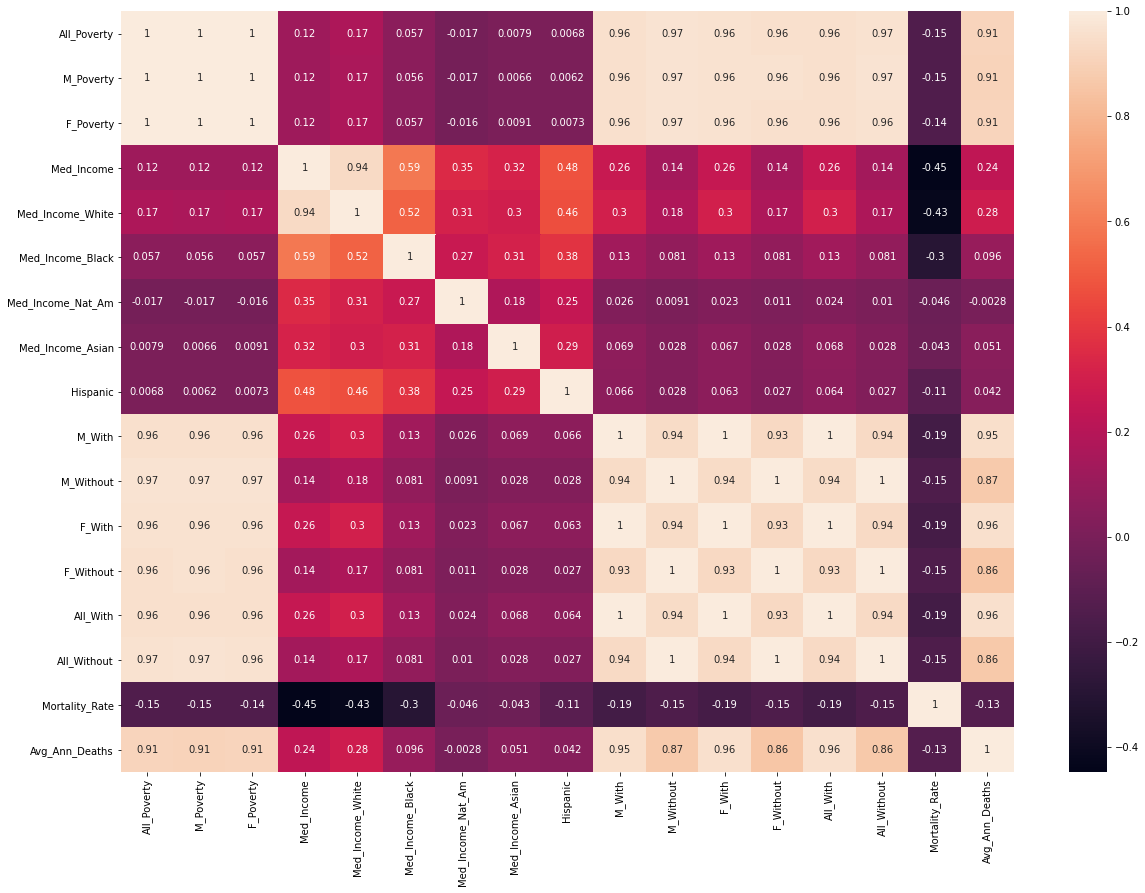

In [4]:
drop_cols = ['FIPS', 'fips_x','fips_y'] ## dropping zipcodes
data = df.drop(drop_cols, axis=1)
plt.figure(figsize=(20,14))
sns.heatmap(data.corr(), annot=True) # plotting heatmap with correlation between numeric features

In [5]:
def dist_plot(features, rows, cols, data=data, figsize=(10,7)):
  #### function to plot distributions of features in subplots and also print mean of the distribution in each subplot
  fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)
  for i,ax in enumerate(axes.flatten()):
    x=data[features[i]]
    sns.distplot(x, ax=ax)
    ax.title.set_text(features[i])
    kdeline = ax.lines[0]
    mean = x.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax.vlines(mean, 0, height, color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.text(0.75, 0.9, "Mean: {:.2f}".format(x.mean()), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

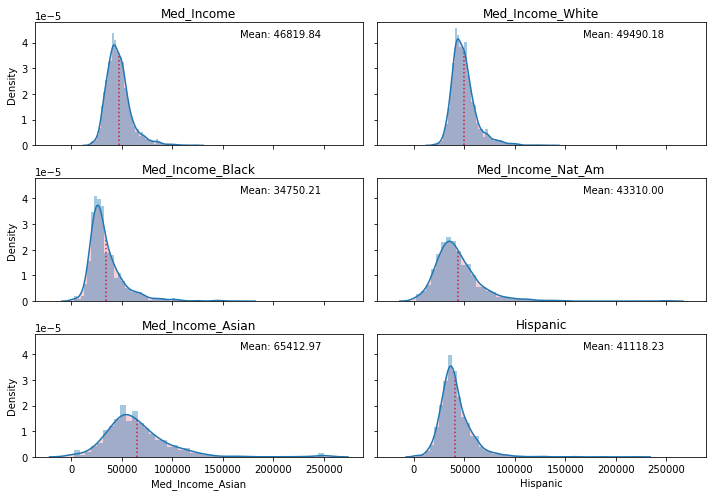

In [6]:
income = [ 'Med_Income','Med_Income_White',
       'Med_Income_Black', 'Med_Income_Nat_Am', 'Med_Income_Asian', 'Hispanic'] ## all features related to income
dist_plot(income, 3,2)

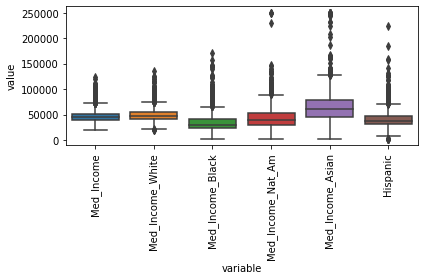

In [7]:
ax = sns.boxplot(x='variable', y='value', data=pd.melt(data[income]))  ##boxplot of incomes of various ethnic groups
ax.tick_params(axis='x', rotation=90)
plt.tight_layout() # blacks have the lowest median income

In [8]:
data['Incidence_Rate'] = data['Incidence_Rate'].astype(str).str.replace(' #', '').astype(float)  ## cleaning noisy characters from features
data['Avg_Ann_Incidence'] = data['Avg_Ann_Incidence'].astype(str).str.replace('or fewer', '').astype(float)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


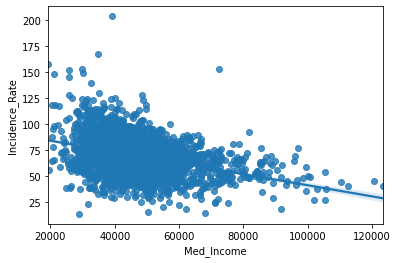

In [9]:
## plot of median income vs incidence rates
sns.regplot(data['Med_Income'], data['Incidence_Rate'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


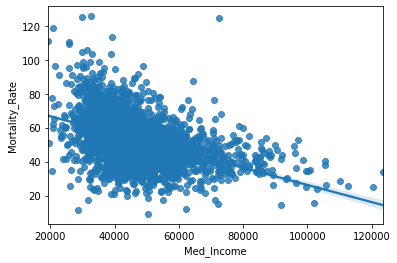

In [10]:
## plot of median income vs mortality rates
sns.regplot(data['Med_Income'], data['Mortality_Rate'])

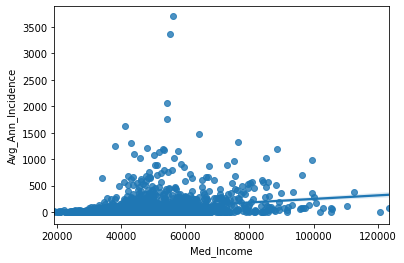

In [11]:
## plot of median income vs average annual incidence
sns.regplot(x=data['Med_Income'], y=data['Avg_Ann_Incidence'].astype(float))

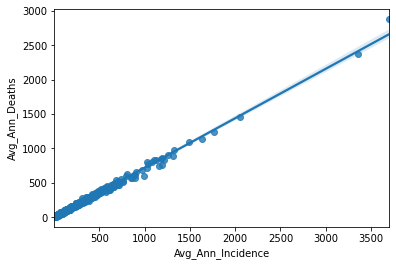

In [12]:
# plot of average annual incidence vs deaths
sns.regplot(x=data['Avg_Ann_Incidence'], y=data['Avg_Ann_Deaths'].astype(float))

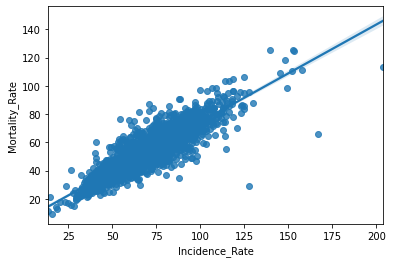

In [13]:
# plot of incidence vs mortality rates for all areas
sns.regplot(x=data['Incidence_Rate'], y=data['Mortality_Rate'].astype(float))

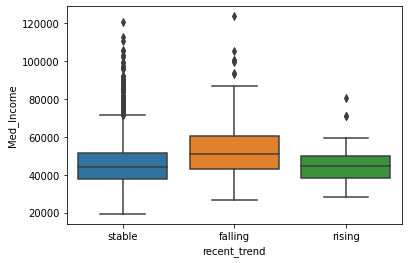

In [14]:
# boxplot for recent trend vs median income
sns.boxplot(x='recent_trend', y='Med_Income', data=data)

In [15]:
## obtaining averages of all areas in each state
state_df = data.groupby('State').agg('mean')
state_df.sort_values(by='Mortality_Rate')

,All_Poverty,M_Poverty,F_Poverty,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths
State,,,,,,,,,,,,,,,,,,,
UT,12124.172414,5646.620690,6477.551724,54687.034483,55952.068966,47773.875000,42278.875000,68741.818182,37441.208333,42691.068966,6939.689655,43393.172414,6177.206897,86084.241379,13116.896552,31.910526,22.241379,22.964706,24.764706
HI,30788.800000,14142.200000,16646.600000,64879.000000,63301.250000,57288.000000,51644.000000,68667.750000,53055.500000,123945.400000,8997.200000,130480.400000,7047.000000,254425.800000,16044.200000,45.400000,155.800000,32.350000,134.250000
CO,10218.265625,4729.312500,5488.953125,51263.187500,52227.531250,52339.160000,40662.096774,58136.000000,38749.483871,34745.546875,5534.781250,36322.625000,4447.265625,71068.171875,9982.046875,44.689583,35.281250,33.240000,39.075000
NM,13010.939394,6034.939394,6976.000000,40183.666667,42952.757576,38032.600000,37426.130435,67274.142857,34024.181818,25007.909091,5452.000000,26911.939394,4740.333333,51919.848485,10192.333333,44.437037,29.424242,33.730769,27.653846
AZ,78712.666667,36501.133333,42211.533333,43252.200000,45663.600000,53071.363636,35378.615385,61901.769231,38478.066667,178389.533333,35436.066667,191685.466667,30056.200000,370075.000000,65492.266667,48.366667,252.600000,35.180000,182.666667
WY,2825.869565,1255.739130,1570.130435,57042.304348,57762.086957,32669.000000,62420.111111,46094.800000,46368.200000,10802.956522,1764.608696,10670.782609,1552.869565,21473.739130,3317.478261,46.842857,12.739130,38.409524,10.857143
CA,105778.310345,48712.758621,57065.551724,56013.155172,58284.137931,46367.782609,44473.222222,68269.591837,44209.910714,269831.241379,52388.275862,287728.534483,43712.500000,557559.775862,96100.775862,51.632143,294.396552,39.374545,231.818182
DC,110365.000000,48069.000000,62296.000000,70848.000000,115890.000000,40677.000000,61985.000000,83064.000000,61087.000000,276285.000000,22198.000000,323314.000000,14813.000000,599599.000000,37011.000000,59.000000,351.000000,40.600000,240.000000
ID,5572.204545,2591.636364,2980.568182,43607.750000,44077.136364,49256.000000,37992.000000,48983.285714,39515.189189,15305.886364,2773.363636,15626.613636,2562.863636,30932.500000,5336.227273,54.005882,19.500000,41.693103,20.586207


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


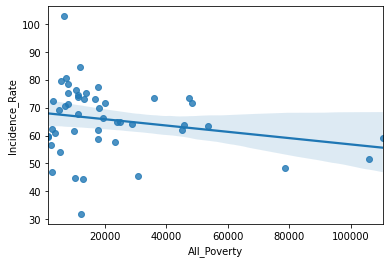

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


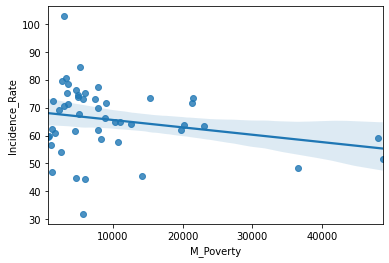

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


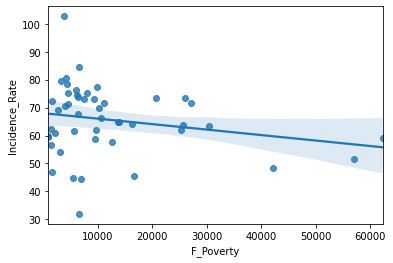

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


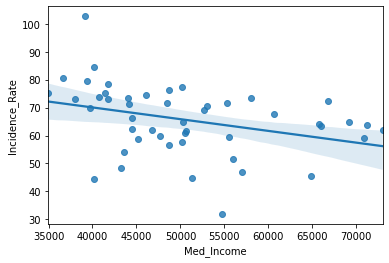

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


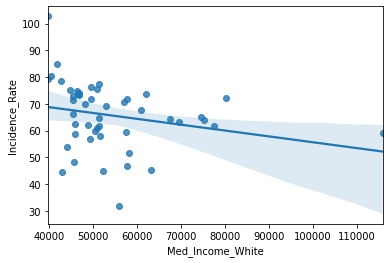

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


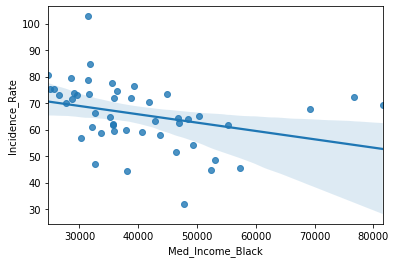

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


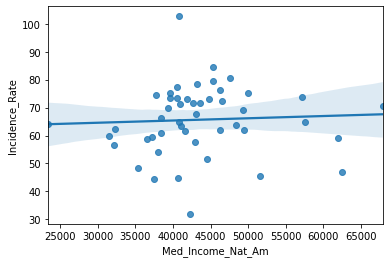

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


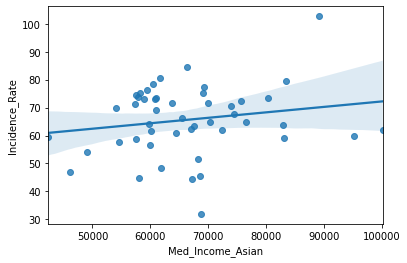

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


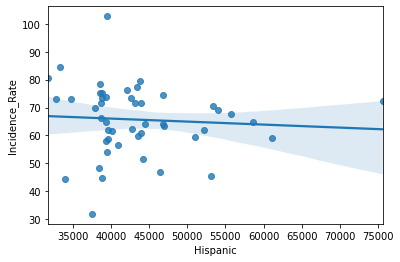

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


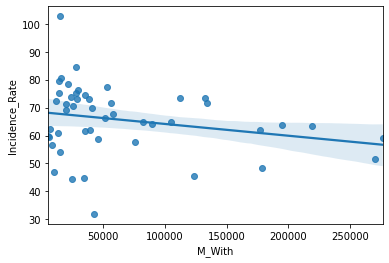

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


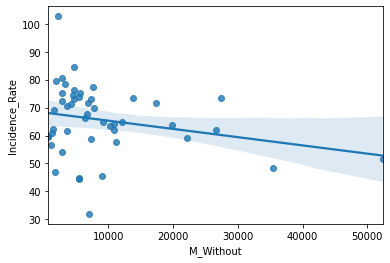

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


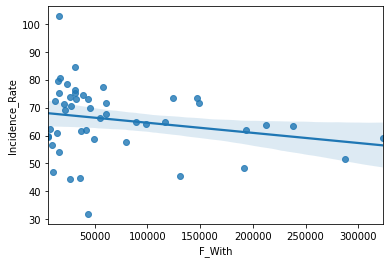

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


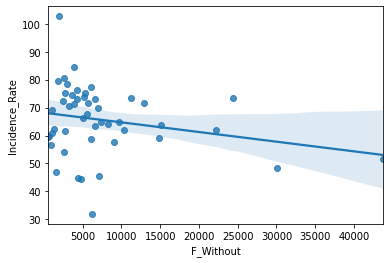

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


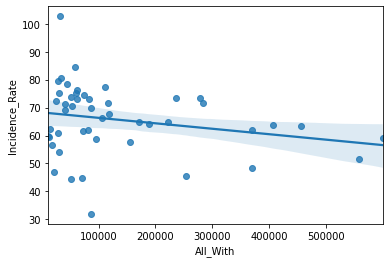

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


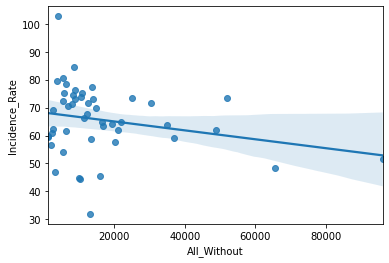

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


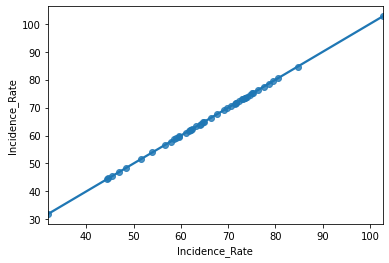

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


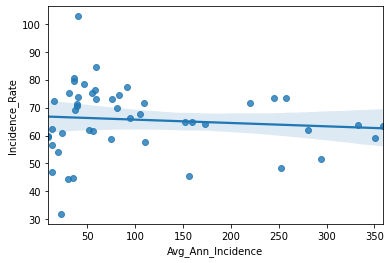

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


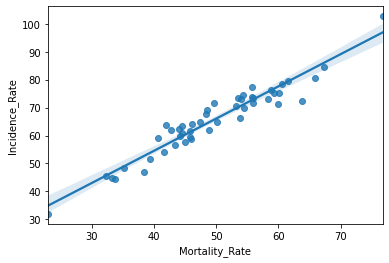

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


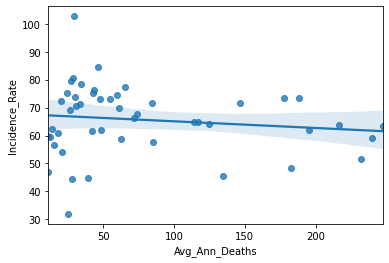

In [16]:
## plotting numeric features against incidence rate
feature = ['All_Poverty', 'M_Poverty', 'F_Poverty', 'Med_Income',
       'Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am',
       'Med_Income_Asian', 'Hispanic', 'M_With', 'M_Without', 'F_With',
       'F_Without', 'All_With', 'All_Without', 'Incidence_Rate',
       'Avg_Ann_Incidence', 'Mortality_Rate', 'Avg_Ann_Deaths']
for i in feature:
  sns.regplot(state_df[i], state_df['Incidence_Rate'])
  plt.show()

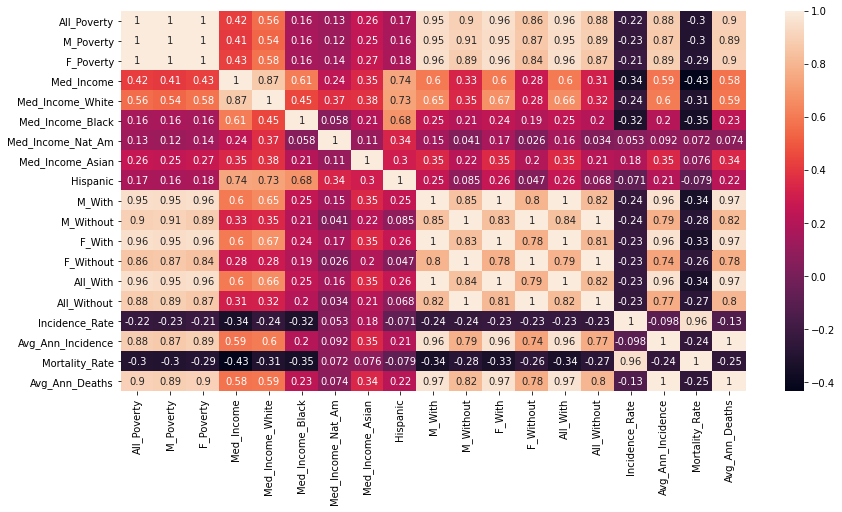

In [17]:
## plotting heatmap with correlation after cleaning of features 
plt.figure(figsize=(14,7))
sns.heatmap(state_df.corr(), annot=True)

# Further Exploratory Data Analysis

In [18]:
########## POTENTIAL DIRECTIONS OF EXPLORATION

## recent trend vs incomes of groups (black, white, hispanic, Asian, etc.)
## mortality and incidence in areas where more females poor than males
## states in which blacks are paid more than median; less mortality?
## states in which whites are paid more than median; less mortality?
## number of groups above median, below (H, A, Am, B, W), (0,1,....5) average mortality and incidence for each
## Insurance and poverty; more people with insurance => less poverty?
## more males with insurance, vs more females with insurance (confusion matrix)
## (males more, more than median cases), etc etc
## Income of each group vs Insurance => Which group purchases insurance more (eg. Asian)
## Income vs (males or females buying more insurance) (Eg. in poor households, males buy more; in rich households females buy more)
## ANOVA to check if incomes of all groups are same

In [19]:
data = df.drop(drop_cols, axis=1)

data.columns = ['state', 'area_name', 'num_poverty', 'num_poverty_male', 'num_poverty_female',
       'median_income', 'white_income', 'black_income',
       'american_income', 'asian_income', 'hispanic_income', 'with_insurance_male',
       'without_insurance_male', 'with_insurance_female', 'without_insurance_female', 'with_insurance', 'without_insurance',
       'incidence_rate', 'avg_ann_incidence', 'recent_trend', 'mortality_rate',
       'avg_ann_deaths']   ### renaming all columns for convenience

income = ['median_income', 'white_income', 'black_income',
       'american_income', 'asian_income', 'hispanic_income'] # all features related to income
insurance = ['with_insurance_male',
       'without_insurance_male', 'with_insurance_female', 'without_insurance_female', 'with_insurance', 'without_insurance'] # all features related to insurance
rates = ['incidence_rate', 'avg_ann_incidence', 'mortality_rate',
       'avg_ann_deaths'] ## all potential dependent variables
rate2 = ['incidence_rate', 'mortality_rate'] ## dependent variables used in this study

In [20]:
for i in rates:   #### cleaning all noisy features
  data[i] = data[i].astype(str).str.replace(' #', '').str.replace(' or fewer', '').astype(float)

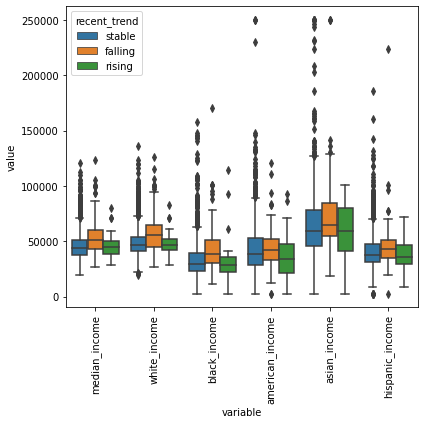

In [21]:
plt.figure(figsize=(6,6))
x = pd.melt(data[['recent_trend']+income], id_vars='recent_trend')
ax = sns.boxplot(x='variable', y='value', hue='recent_trend', data=x)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [22]:
data['more_females_poor'] = (data['num_poverty_male']<data['num_poverty_female']).astype('int') ## setting more_females_poor to 1 whenever an area has more poor females than poor males
data['more_females_poor'].value_counts()

1    2899
0     235
Name: more_females_poor, dtype: int64

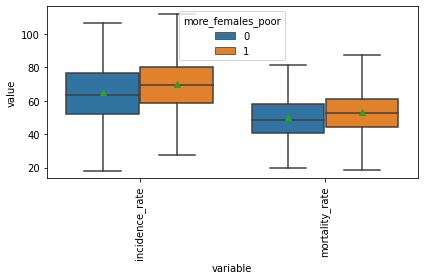

In [23]:
x = pd.melt(data[rate2+ ['more_females_poor']], id_vars='more_females_poor')
ax = sns.boxplot(x='variable', y='value', hue='more_females_poor', data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [24]:
new_cols = []  ## creating features where value = 1 when income of ethnic group > median income and 0 otherwise
for i in income[1:]:
  data['{}_more'.format(i)] = (data['median_income']<data[i]).astype('int')
  new_cols.append('{}_more'.format(i))

data['num_groups_above_median'] = data[new_cols].sum(axis=1) ## number of ethnic groups in the area earning above median income of the area
data['num_groups_above_median'].value_counts()

1    1502
2    1149
3     293
0     162
4      28
Name: num_groups_above_median, dtype: int64

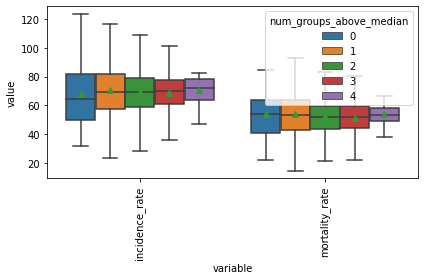

In [25]:
# relation of number of ethnic groups earning above median and incidence/mortality
x = pd.melt(data[rate2+ ['num_groups_above_median']], id_vars='num_groups_above_median')
ax = sns.boxplot(x='variable', y='value', hue='num_groups_above_median', data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

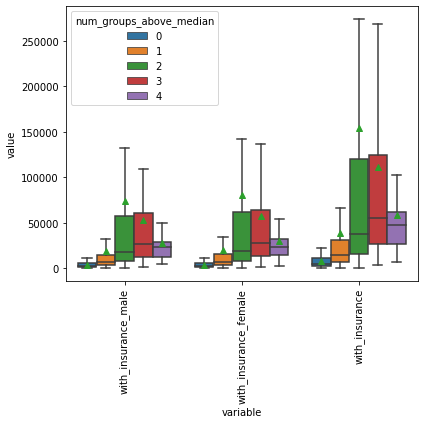

In [26]:
# relation of number of ethnic groups earning above median and insurance subscription
plt.figure(figsize=(6,6))
x = pd.melt(data[['with_insurance_male','with_insurance_female', 'with_insurance','num_groups_above_median']], id_vars='num_groups_above_median')
ax = sns.boxplot(x='variable', y='value', hue='num_groups_above_median', data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

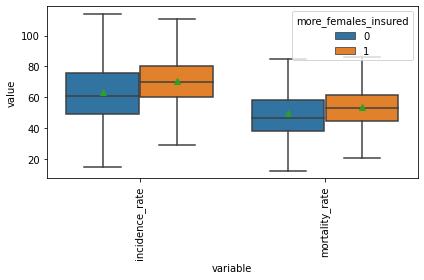

In [27]:
data['more_females_insured'] = (data['with_insurance_male']<data['with_insurance_female']).astype('int') ## creating feature with value = 1 
## when more females in an area have insurance than males
i = 'more_females_insured'
x = pd.melt(data[rate2+ [i]], id_vars=i)
ax = sns.boxplot(x='variable', y='value', hue=i, data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [28]:
data['more_females_insured'].value_counts()  ## number of areas with more females insured than males

1    2590
0     544
Name: more_females_insured, dtype: int64

In [29]:
## correlation matrix of more females insured and incidence/mortality
data[['state', 'more_females_insured']+rates].groupby('state').agg('mean').sort_values(by='incidence_rate').corr()

,more_females_insured,incidence_rate,avg_ann_incidence,mortality_rate,avg_ann_deaths
more_females_insured,1.000000,0.388867,0.498575,0.245097,0.477164
incidence_rate,0.388867,1.000000,-0.097523,0.960080,-0.134527
avg_ann_incidence,0.498575,-0.097523,1.000000,-0.237780,0.995588
mortality_rate,0.245097,0.960080,-0.237780,1.000000,-0.245166
avg_ann_deaths,0.477164,-0.134527,0.995588,-0.245166,1.000000


In [30]:
### GET NUMBER OF MALES AND FEMALES IN EACH AREA
data['total_male'] = data['with_insurance_male']+data['without_insurance_male'] ## total number of males in an area

In [31]:
x = data['with_insurance_female']+data['without_insurance_female']
y = data['with_insurance_male']+data['without_insurance_male']
print(((x+y)==(data['with_insurance']+data['without_insurance'])).value_counts()) ## asserting that sums are equal
data['female_ratio'] = x/(x+y) # ratio of females in the total population
data['male_ratio']=y/(x+y) # ratio of males in the total population
total_people = x+y
data['more_females'] = (data['male_ratio']<data['female_ratio']).astype('int') #value is 1 when an area has higher proportion of females
data['more_females'].value_counts()

True    3134
dtype: int64


1    2316
0     818
Name: more_females, dtype: int64

In [32]:
x1 = data['num_poverty_female']/x ## ratio of poor females to total number of females
y1 = data['num_poverty_male']/y ## ratio of poor males to total number of males
print(((data['num_poverty_female']+data['num_poverty_male'])==data['num_poverty']).value_counts()) ## asserting number of poor males and females equals total number of poor people

data['poverty_female_ratio'] = x1 
data['poverty_male_ratio']=y1
data['total_population'] = x+y
data['more_females_poor'] = (data['poverty_male_ratio']<data['poverty_female_ratio']).astype('int')
data['poverty_ratio'] = data['num_poverty']/total_people

True    3134
dtype: int64


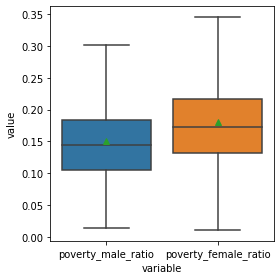

In [33]:
## distribution of poverty ratio among males and females, on an average, females are seen to be more poor
plt.figure(figsize=(4,4))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(data[['poverty_male_ratio', 'poverty_female_ratio']]), showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()

In [34]:
data.value_counts(['more_females', 'more_females_poor']) # contingency table of areas with more/less females and more/less poor females

more_females  more_females_poor
1             1                    2199
0             1                     716
1             0                     117
0             0                     102
dtype: int64

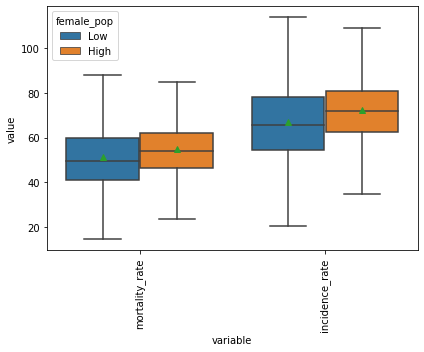

In [35]:
## binarising female population into hgh and low and seeing trend of incidence/mortality
fem = data['female_ratio'].median()
data['female_pop'] = 'High'
data.loc[data['female_ratio']<fem,'female_pop']='Low'
plt.figure(figsize=(6,5))
i = 'female_pop'
rate2 = ['mortality_rate', 'incidence_rate']
x = pd.melt(data[rate2+ [i]], id_vars=i)
ax = sns.boxplot(x='variable', y='value', hue=i, data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

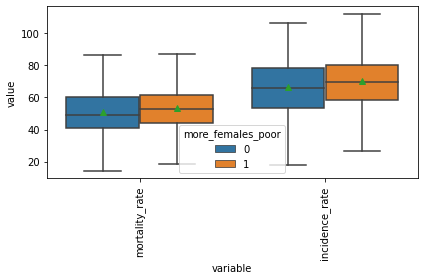

In [36]:
# boxplot of incidence/mortality in areas with more poor females than poor males, and vice versa
i = 'more_females_poor'
x = pd.melt(data[rate2+ [i]], id_vars=i)
ax = sns.boxplot(x='variable', y='value', hue=i, data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [37]:
## CATEGORISING POVERTY ACCORDING TO POVERTY RATTIO AND MEDIAN INCOME
median_pov_ratio = data['poverty_ratio'].mean()
median_med_income = data['median_income'].mean()
data['poverty_category']=None
data.loc[(data.median_income<median_med_income)&((data.poverty_ratio>median_pov_ratio)), 'poverty_category']='most_poor'
data.loc[(data.median_income>median_med_income)&((data.poverty_ratio>median_pov_ratio)), 'poverty_category']='many_poor_few_very_rich'
data.loc[(data.median_income<median_med_income)&((data.poverty_ratio<median_pov_ratio)), 'poverty_category']='few_very_poor_many_rich'
data.loc[(data.median_income>median_med_income)&((data.poverty_ratio<median_pov_ratio)), 'poverty_category']='many_rich'
data.poverty_category.value_counts()

most_poor                  1298
many_rich                  1237
few_very_poor_many_rich     463
many_poor_few_very_rich     135
Name: poverty_category, dtype: int64

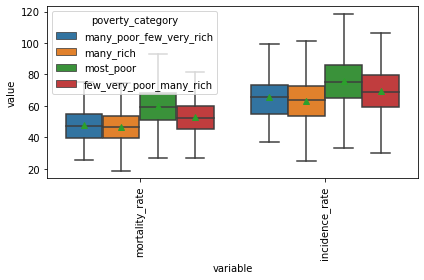

In [38]:
# PLOTTING MORTALITY AND INCIDENCE FOR ALL POVERTY CATEGORIES
i = 'poverty_category'
x = pd.melt(data[rate2+ [i]], id_vars=i)
ax = sns.boxplot(x='variable', y='value', hue=i, data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

In [39]:
#### CATEGORISING INSURANCE SUBSCRIPTIONS AMONG MALES AND FEMALES

data['female_insurance_rate'] = data['with_insurance_female']/(data['with_insurance_female']+data['without_insurance_female'])
data['male_insurance_rate'] = data['with_insurance_male']/(data['with_insurance_male']+data['without_insurance_male'])
median_male = data['with_insurance_male'].median()
median_female = data['with_insurance_female'].median()
data['insurance_ratios']=None
data.loc[(data.with_insurance_female<median_female)&((data.with_insurance_male>median_male)), 'insurance_ratios']='low_female_high_male'
data.loc[(data.with_insurance_female>median_female)&((data.with_insurance_male>median_male)), 'insurance_ratios']= 'high_female_high_male'
data.loc[(data.with_insurance_female<median_female)&((data.with_insurance_male<median_male)), 'insurance_ratios']='low_female_low_male'
data.loc[(data.with_insurance_female>median_female)&((data.with_insurance_male<median_male)), 'insurance_ratios']='high_female_high_male'
data['insurance_ratios'].value_counts()

high_female_high_male    1567
low_female_low_male      1547
low_female_high_male       20
Name: insurance_ratios, dtype: int64

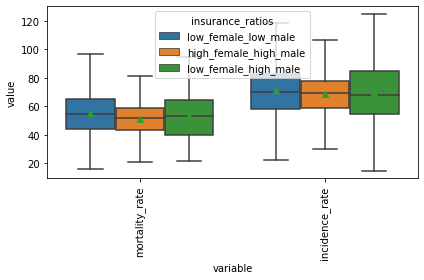

In [40]:
# plotting incidence/mortality for various insurance subscription categories
i = 'insurance_ratios'
rate2 = ['mortality_rate', 'incidence_rate']
x = pd.melt(data[rate2+ [i]], id_vars=i)
ax = sns.boxplot(x='variable', y='value', hue=i, data=x, showfliers=False, showmeans=True)
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

# Models

## Preparing Data: Handling Multicollinearity and Missing Values




In [41]:
###### HANDLING MULTICOLLINEARITY AND MISSING VALUES: dropping highly correlated features and missing values

corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
if 'mortality_rate' in to_drop:
  to_drop.remove('mortality_rate')

ind1 = data.drop(to_drop, axis=1)
ind = ind1.dropna() ##### dropped missing values after dropping dependent columns

X = ind.drop(['state', 'area_name', 'recent_trend', 'poverty_category', 'incidence_rate', 'mortality_rate', 'insurance_ratios', 'female_pop'], axis=1)
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)  # polynomial features dataset
X = X/X.max() # normalizing features
y1 = ind['incidence_rate'] ## dependent variable 1
y2 = ind['mortality_rate'] ## dependent variable 1

## Model-1: Num_Poverty Only

In [42]:
### using only num_poverty

X1_train, X1_val, y1_train, y1_val =  train_test_split(X, y1, test_size=0.2, random_state=0) ## splitting features and incidence with 80-20 split
X2_train, X2_val, y2_train, y2_val =  train_test_split(X, y2, test_size=0.2, random_state=0) ## splitting features and mortality with 80-20 split

features = ['num_poverty'] ## modelling using num_poverty only

reg1 = LinearRegression().fit(X1_train[features], y1_train) # training model for incidence
print("Train R2 score for incidence: ", reg1.score(X1_train[features], y1_train))

y1_pred = reg1.predict(X1_val[features]) #predictions
print("Test R2 score for incidence: ",r2_score(y1_val, y1_pred))

reg2 = LinearRegression().fit(X2_train[features], y2_train) # training model for mortality
print("Train R2 score for mortality: ",reg2.score(X2_train[features], y2_train))

y2_pred = reg2.predict(X2_val[features]) #predictions
print("Test R2 score for mortality: ",r2_score(y2_val, y2_pred))

Train R2 score for incidence:  0.043468459515555335
Test R2 score for incidence:  0.04803478128251515
Train R2 score for mortality:  0.05064381278187591
Test R2 score for mortality:  0.04514559314104383


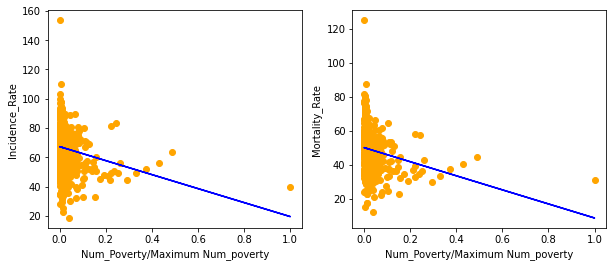

In [43]:
## plotting data and model learnt
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X[features], y1, color = "orange")
ax[0].plot(X[features], reg1.predict(X[features]), color = "blue")
ax[0].set_xlabel("Num_Poverty/Maximum Num_poverty")
ax[0].set_ylabel("Incidence_Rate")

ax[1].scatter(X[features], y2, color = "orange")
ax[1].plot(X[features], reg2.predict(X[features]), color = "blue")
ax[1].set_xlabel("Num_Poverty/Maximum Num_poverty")
ax[1].set_ylabel("Mortality_Rate")
plt.show()

## Model-2: Using Poverty and Median Income

In [44]:
#### POVERTY AND MEDIAN INCOME
X1_train, X1_val, y1_train, y1_val =  train_test_split(X, y1, test_size=0.2,random_state=100)
X2_train, X2_val, y2_train, y2_val =  train_test_split(X, y2, test_size=0.2, random_state=100)
features = ['num_poverty', 'median_income']


reg1 = LinearRegression().fit(X1_train[features], y1_train)
print("Train R2 score for incidence: ", reg1.score(X1_train[features], y1_train))

y_pred = reg1.predict(X1_val[features])
print("Test R2 score for incidence: ",r2_score(y1_val, y_pred))

reg2 = LinearRegression().fit(X2_train[features], y2_train)
print("Train R2 score for mortality: ",reg2.score(X2_train[features], y2_train))

y_pred = reg2.predict(X2_val[features])
print("Test R2 score for mortality: ",r2_score(y2_val, y_pred))

Train R2 score for incidence:  0.17489984379982212
Test R2 score for incidence:  0.21216818505702295
Train R2 score for mortality:  0.20730851429790298
Test R2 score for mortality:  0.3043109589517241


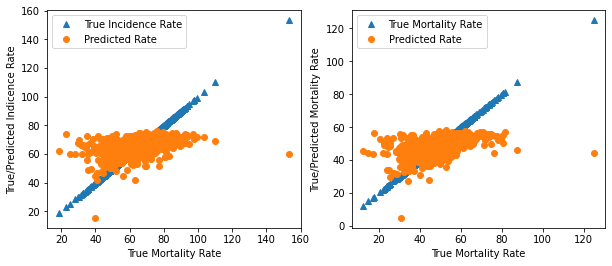

In [45]:
## plotting true value vs outcome
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(y1,y1, '^', label="True Incidence Rate")
ax[0].plot(y1,reg1.predict(X[features]), 'o', label = "Predicted Rate")
ax[0].set_xlabel("True Mortality Rate")
ax[0].set_ylabel("True/Predicted Indicence Rate")
ax[0].legend()

ax[1].plot(y2,y2, '^', label="True Mortality Rate")
ax[1].plot(y2,reg2.predict(X[features]), 'o', label = "Predicted Rate")
ax[1].set_xlabel("True Mortality Rate")
ax[1].set_ylabel("True/Predicted Mortality Rate")
ax[1].legend()

## Model-3: Using Polynomial Features

In [46]:
##### POLYNOMIAL FEATURES

X1_train, X1_val, y1_train, y1_val =  train_test_split(X_poly, y1, test_size=0.2,random_state=100)
X2_train, X2_val, y2_train, y2_val =  train_test_split(X_poly, y2, test_size=0.2, random_state=100)
reg1 = LinearRegression().fit(X1_train, y1_train)
print("Train R2 score for incidence: ", reg1.score(X1_train, y1_train))

y1_pred = reg1.predict(X1_val)
print("Test R2 score for incidence: ",r2_score(y1_val, y1_pred))

reg2 = LinearRegression().fit(X2_train, y2_train)
print("Train R2 score for mortality: ",reg2.score(X2_train, y2_train))

y2_pred = reg2.predict(X2_val)
print("Test R2 score for mortality: ",r2_score(y2_val, y2_pred))

Train R2 score for incidence:  0.6132422386766807
Test R2 score for incidence:  -1.041654355348908
Train R2 score for mortality:  0.5058249702932076
Test R2 score for mortality:  -12.463630734114494


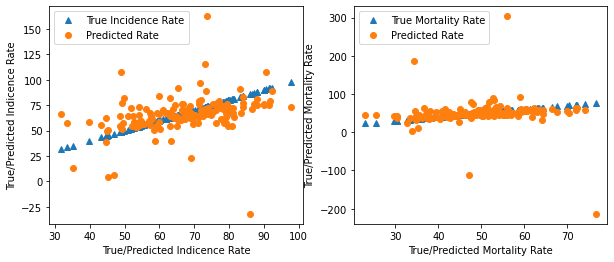

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(y1_val,y1_val, '^', label="True Incidence Rate")
ax[0].plot(y1_val,reg1.predict(X1_val), 'o', label = "Predicted Rate")
ax[0].set_xlabel("True/Predicted Indicence Rate")
ax[0].set_ylabel("True/Predicted Indicence Rate")
ax[0].legend()

ax[1].plot(y2_val,y2_val, '^', label="True Mortality Rate")
ax[1].plot(y2_val,reg2.predict(X2_val), 'o', label = "Predicted Rate")
ax[1].set_xlabel("True/Predicted Mortality Rate")
ax[1].set_ylabel("True/Predicted Mortality Rate")
ax[1].legend()

## Model-4: Using Engineered Features

In [48]:
#### USING ENGINEERED FEATURES

drop_features = ['black_income', 'asian_income_more', 'hispanic_income_more','num_groups_above_median', 'more_females_insured'] # removing features with p-value > 0.1
X1_train, X1_val, y1_train, y1_val =  train_test_split(X.drop(drop_features, axis=1), y1, test_size=0.2,random_state=100)
X2_train, X2_val, y2_train, y2_val =  train_test_split(X.drop(drop_features, axis=1), y2, test_size=0.2, random_state=100)
model = sm.OLS(y1_train, X1_train)
results = model.fit()
print(results.summary())
print("\n Test R2 score for mortality: ",r2_score(y1_val, results.predict(X1_val)))
y1pred = results.predict(X.drop(drop_features, axis=1))

                                 OLS Regression Results                                
Dep. Variable:         incidence_rate   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              1344.
Date:                Fri, 17 Sep 2021   Prob (F-statistic):                        0.00
Time:                        11:04:33   Log-Likelihood:                         -2263.7
No. Observations:                 581   AIC:                                      4553.
Df Residuals:                     568   BIC:                                      4610.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [49]:
drop_features = ['black_income', 'asian_income_more', 'hispanic_income_more','num_groups_above_median', 'more_females_insured'] # removing features with p-value > 0.1
X1_train, X1_val, y1_train, y1_val =  train_test_split(X.drop(drop_features, axis=1), y1, test_size=0.2,random_state=100)
X2_train, X2_val, y2_train, y2_val =  train_test_split(X.drop(drop_features, axis=1), y2, test_size=0.2, random_state=100)
model = sm.OLS(y2_train, X2_train)
results = model.fit()
print(results.summary())
print("\n Test R2 score for mortality: ",r2_score(y2_val, results.predict(X2_val)))
y2pred = results.predict(X.drop(drop_features, axis=1))

                                 OLS Regression Results                                
Dep. Variable:         mortality_rate   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              1066.
Date:                Fri, 17 Sep 2021   Prob (F-statistic):                        0.00
Time:                        11:04:33   Log-Likelihood:                         -2161.6
No. Observations:                 581   AIC:                                      4349.
Df Residuals:                     568   BIC:                                      4406.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

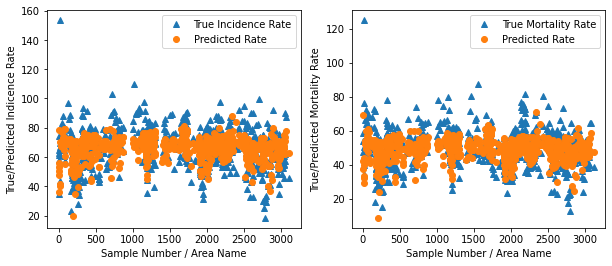

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(y1, '^', label="True Incidence Rate")
ax[0].plot(y1pred, 'o', label = "Predicted Rate")
ax[0].set_xlabel("Sample Number / Area Name")
ax[0].set_ylabel("True/Predicted Indicence Rate")
ax[0].legend()

ax[1].plot(y2, '^', label="True Mortality Rate")
ax[1].plot(y2pred, 'o', label = "Predicted Rate")
ax[1].set_xlabel("Sample Number / Area Name")
ax[1].set_ylabel("True/Predicted Mortality Rate")
ax[1].legend()